In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [77]:
df_train = pd.read_parquet("./data/df_train_preprocessing.parquet")
df_val = pd.read_parquet("./data/df_test_preprocessing.parquet")
df_test = pd.read_parquet("./data/df_val_preprocessing.parquet")

X_train, y_train = df_train.drop(columns="isFraud"), df_train["isFraud"]
X_val, y_val = df_val.drop(columns="isFraud"), df_val["isFraud"]
X_test, y_test = df_test.drop(columns="isFraud"), df_test["isFraud"]

In [78]:
rf_model = RandomForestClassifier(
    n_estimators=40,
    max_depth=8,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf_model.fit(X_train, y_train)
baseline_roc_auc = roc_auc_score(y_val, rf_model.predict_proba(X_val)[:, 1])
print("Baseline Val ROC-AUC:", baseline_roc_auc)
print("Baseline Test ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

lofo_scores = [(col, baseline_roc_auc - roc_auc_score(y_val, rf_model.predict_proba(X_val.assign(**{col: X_val[col].mean()}))[:, 1])) for col in X_train.columns]
lofo_df = pd.DataFrame(lofo_scores, columns=["feature", "score_drop"]).sort_values("score_drop")

drop_lofo_cols = lofo_df.loc[lofo_df["score_drop"] <= 0, "feature"].tolist()
if drop_lofo_cols:
    print("\nColumns dropped due to LOFO score <= 0:", drop_lofo_cols)
    X_train = X_train.drop(columns=drop_lofo_cols)
    X_val = X_val.drop(columns=drop_lofo_cols)
    X_test = X_test.drop(columns=drop_lofo_cols)

corr_matrix = X_train.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

drop_corr_cols = []
for col in upper_triangle.columns:
    for row in upper_triangle.index:
        if upper_triangle.loc[row, col] > 0.9:
            score_col = lofo_df.loc[lofo_df.feature == col, "score_drop"].values[0]
            score_row = lofo_df.loc[lofo_df.feature == row, "score_drop"].values[0]
            drop_corr_cols.append(col if score_col < score_row else row)

drop_corr_cols = list(set(drop_corr_cols))
if drop_corr_cols:
    print("Columns dropped due to high correlation:", drop_corr_cols)
    X_train = X_train.drop(columns=drop_corr_cols)
    X_val = X_val.drop(columns=drop_corr_cols)
    X_test = X_test.drop(columns=drop_corr_cols)

print("\nFinal selected features:", X_train.columns.tolist())

rf_model.fit(X_train, y_train)
print("Final Val ROC-AUC:", roc_auc_score(y_val, rf_model.predict_proba(X_val)[:, 1]))
print("Final Test ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

Baseline Val ROC-AUC: 0.6215906923517069
Baseline Test ROC-AUC: 0.6609135119671976

Columns dropped due to LOFO score <= 0: ['oldbalanceOrg', 'large_tx', 'balance_recipient_error', 'amount_over_total_balance', 'sender_max_amount', 'step', 'balance_error_total', 'abs_delta_recipient', 'recipient_total_received', 'is_weekend', 'sender_total_amount', 'high_amount_flag', 'isFlaggedFraud', 'is_night', 'type_flag_amount', 'sender_receiver_same', 'time_since_last_tx', 'type_encoded', 'sender_tx_count']
Columns dropped due to high correlation: ['balance_sender_error', 'recipient_tx_count', 'delta_balance_net', 'abs_delta_sender', 'newbalanceDest', 'delta_balance_recipient', 'type_times_amount', 'rolling_max_amount_3', 'rolling_mean_amount_3']

Final selected features: ['amount', 'newbalanceOrig', 'oldbalanceDest', 'delta_balance_sender', 'amount_over_oldbalance', 'amount_over_newbalance', 'hour', 'day', 'amount_over_mean_sender', 'delta_sender_over_recipient', 'amount_over_sender_max', 'recipi

<Figure size 1200x1500 with 0 Axes>

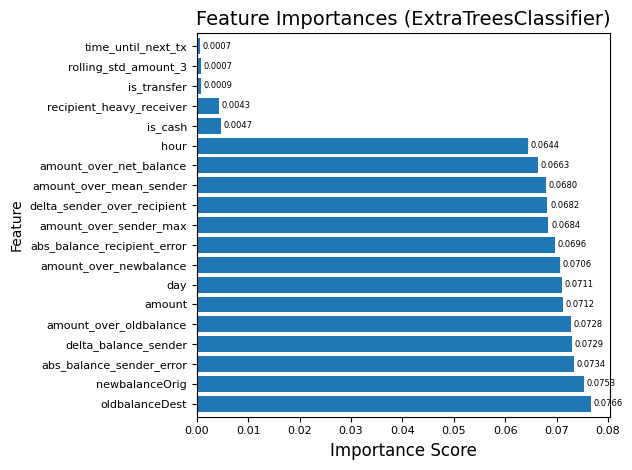

In [79]:
et_model = ExtraTreesClassifier(n_estimators=300, random_state=42, n_jobs=-1)
et_model.fit(X_train, y_train)

importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": et_model.feature_importances_
}).sort_values("importance", ascending=False)

importance_df["importance_norm"] = MinMaxScaler().fit_transform(importance_df[["importance"]])

plt.figure(figsize=(12, max(15, len(importance_df) * 0.5)))
ax = importance_df.plot.barh(x="feature", y="importance", legend=False, width=0.8, fontsize=8)
plt.title("Feature Importances (ExtraTreesClassifier)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=10)

for i, val in enumerate(importance_df["importance"]):
    ax.text(val + 0.0005, i, f"{val:.4f}", fontsize=6, va="center")

plt.tight_layout()
plt.show()

In [80]:
X_train["isFraud"] = y_train
X_val["isFraud"] = y_val
X_test["isFraud"] = y_test

X_train.to_parquet("./data/df_train_features.parquet", index=False)
X_val.to_parquet("./data/df_test_features.parquet", index=False)
X_test.to_parquet("./data/df_val_features.parquet", index=False)